Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
import requests
import zipfile
import os
import pathlib

# URL of the zip file to download
URL = 'https://powergrid1989-my.sharepoint.com/:u:/g/personal/60002716_powergrid_in/ETtB93hsWSNBin7rA_ViLAUBRV42v5yVilY8_m1o2L7NXA?e=fktkMi&download=1'

def download_and_extract_zip(url, destination_folder):
    """Downloads a zip file from a URL and extracts its contents to the specified destination folder."""
    zip_file_path = "temp.zip"  # Temporary file path for the downloaded zip file

    try:
        # Send an HTTP GET request to the URL to download the file
        response = requests.get(url)

        # Check if the request was successful (status code 200)
        response.raise_for_status()

        # Save the zip file to a temporary location
        with open(zip_file_path, "wb") as f:
            f.write(response.content)

        # Create the destination folder if it doesn't exist
        os.makedirs(destination_folder, exist_ok=True)

        # Extract the contents of the zip file
        with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)

        print(f"Zip file downloaded and extracted to: {destination_folder}")

    except requests.exceptions.RequestException as e:
        # Handle any errors that occur during the download process
        print(f"Error downloading file: {e}")

    finally:
        # Ensure the temporary zip file is removed
        if os.path.exists(zip_file_path):
            os.remove(zip_file_path)

# Call the function to download and extract the data
if __name__ == "__main__":
    destination_folder = '/content'  # Set the destination folder to the default working directory in Colab
    download_and_extract_zip(URL, destination_folder)

    # List the extracted files
    extracted_files = os.listdir(destination_folder)
    print("Extracted files:", extracted_files)


Zip file downloaded and extracted to: /content
Extracted files: ['.config', 'Skin cancer ISIC The International Skin Imaging Collaboration', 'sample_data']


In [3]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path(os.path.join(os.getcwd(),'Skin cancer ISIC The International Skin Imaging Collaboration/Train'))
data_dir_test = pathlib.Path(os.path.join(os.getcwd(),'Skin cancer ISIC The International Skin Imaging Collaboration/Test'))

This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [5]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [7]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [8]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [9]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

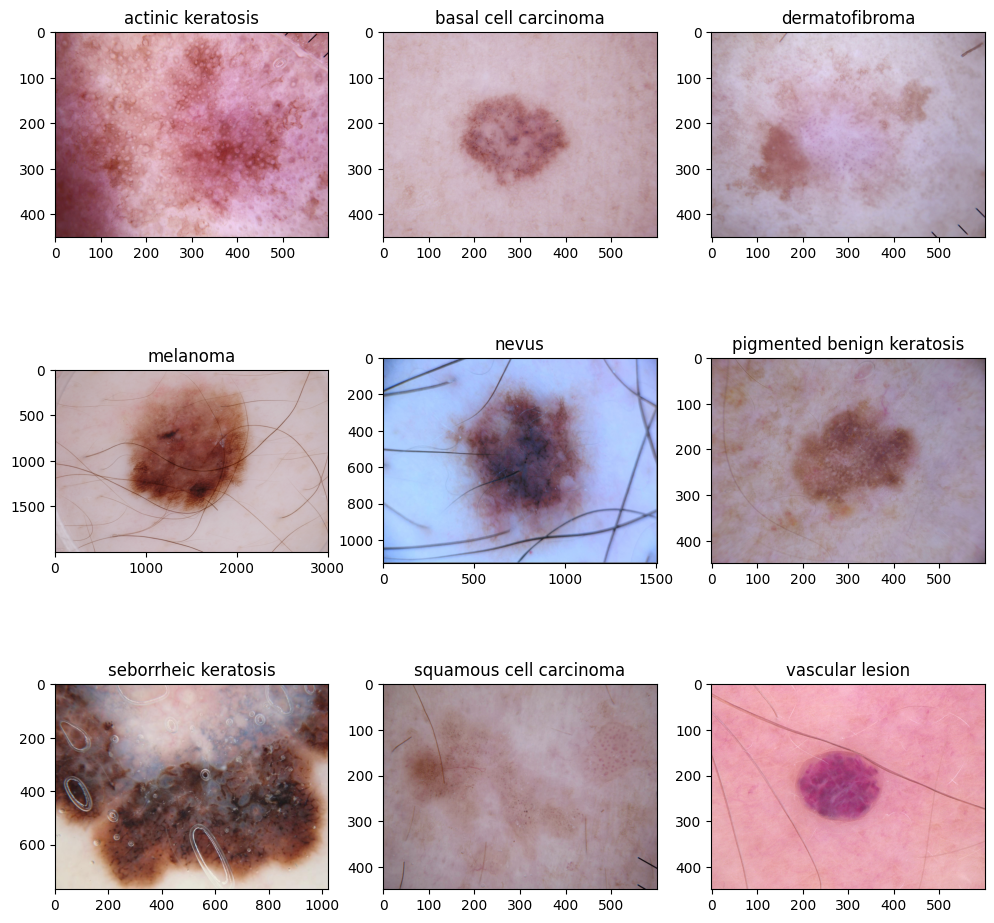

In [10]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# **FIRST MODEL : BASIC CNN MODEL WITHOUT AUGMENTATION AND DROPOUT FEATURE**

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

Let's now build the CNN architecture. We will build a simple shallow-ish CNN model. We will build a network with:

*   Three convolutional layers having 32,64 & 128 layers filters respectively
*   Followed by a max pooling layer,
*   and then Flatten the output of the pooling layer to give us a long vector,
*   then add a fully connected Dense layer with 128 neurons
*   and finally add a softmax layer with 9 neurons


In [17]:
### Your code goes here

# Creating a simple CNN model

from tensorflow.keras import models

# Define the model
model = models.Sequential()

# Input layer with normalization
model.add(layers.InputLayer(input_shape=(img_height,img_width, 3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))  # Normalize pixel values to [0, 1]

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Flatten the output
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))

# Output layer for 9 classes
model.add(layers.Dense(9, activation='softmax'))







### Compile the model
Choose an appropirate optimiser and loss function for model training

In [18]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [19]:
# View the summary of all layers
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 43, 43, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 41, 41, 128)      

### Train the model

In [20]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 49ms/step - loss: 2.0695 - accuracy: 0.2450 - val_loss: 1.7592 - val_accuracy: 0.3960
Epoch 2/20
56/56 [==============================] - 2s 37ms/step - loss: 1.6564 - accuracy: 0.4085 - val_loss: 1.5214 - val_accuracy: 0.4877
Epoch 3/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4536 - accuracy: 0.4972 - val_loss: 1.6142 - val_accuracy: 0.4340
Epoch 4/20
56/56 [==============================] - 2s 34ms/step - loss: 1.4260 - accuracy: 0.5006 - val_loss: 1.4478 - val_accuracy: 0.4698
Epoch 5/20
56/56 [==============================] - 2s 34ms/step - loss: 1.2896 - accuracy: 0.5474 - val_loss: 1.4399 - val_accuracy: 0.5123
Epoch 6/20
56/56 [==============================] - 2s 35ms/step - loss: 1.2595 - accuracy: 0.5575 - val_loss: 1.4276 - val_accuracy: 0.5280
Epoch 7/20
56/56 [==============================] - 2s 34ms/step - loss: 1.1777 - accuracy: 0.5776 - val_loss: 1.4462 - val_accuracy: 0.5078
Epoch 8/20
56

### Visualizing training results

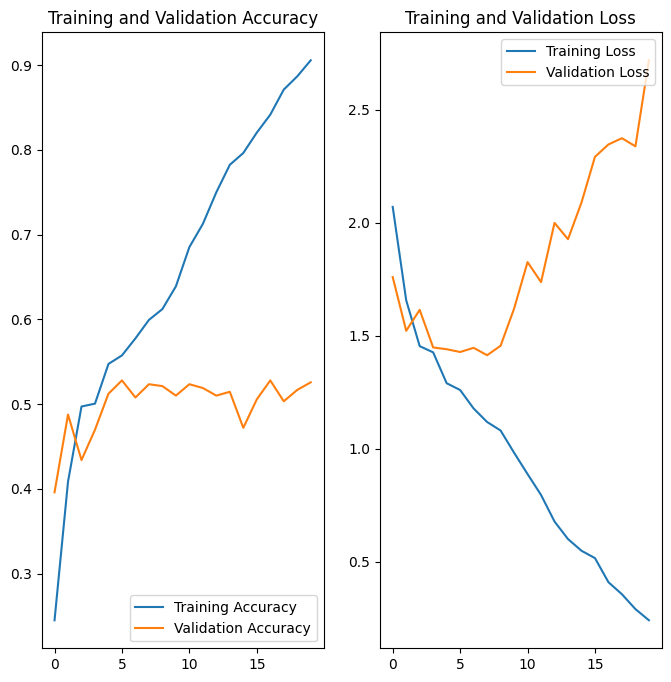

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### Write your findings here

**Finding on the first base model**

The model is overfitting because :

*   While training accuracy is around 90%, validation accuracy is only around 50%.
*   We can also see difference in loss functions in training & test around the 4-5th epoch
*   Validation Loss significantly jumps up after the 15th epoch


A significant gap between training and validation accuracy and a rising validation loss while the training loss continues to decrease, signifies **MODEL OVERFITTING.**

# **SECOND MODEL - WITH AUGMENTATION & DROPOUT FEATURE**

In [22]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = keras.Sequential([
                             layers.experimental.preprocessing.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.experimental.preprocessing.RandomTranslation(.8,.7, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomRotation(0.3, fill_mode='reflect'),
                             layers.experimental.preprocessing.RandomZoom(height_factor=(0.3, 0.4), width_factor=(0.4, 0.3), fill_mode='reflect')
])

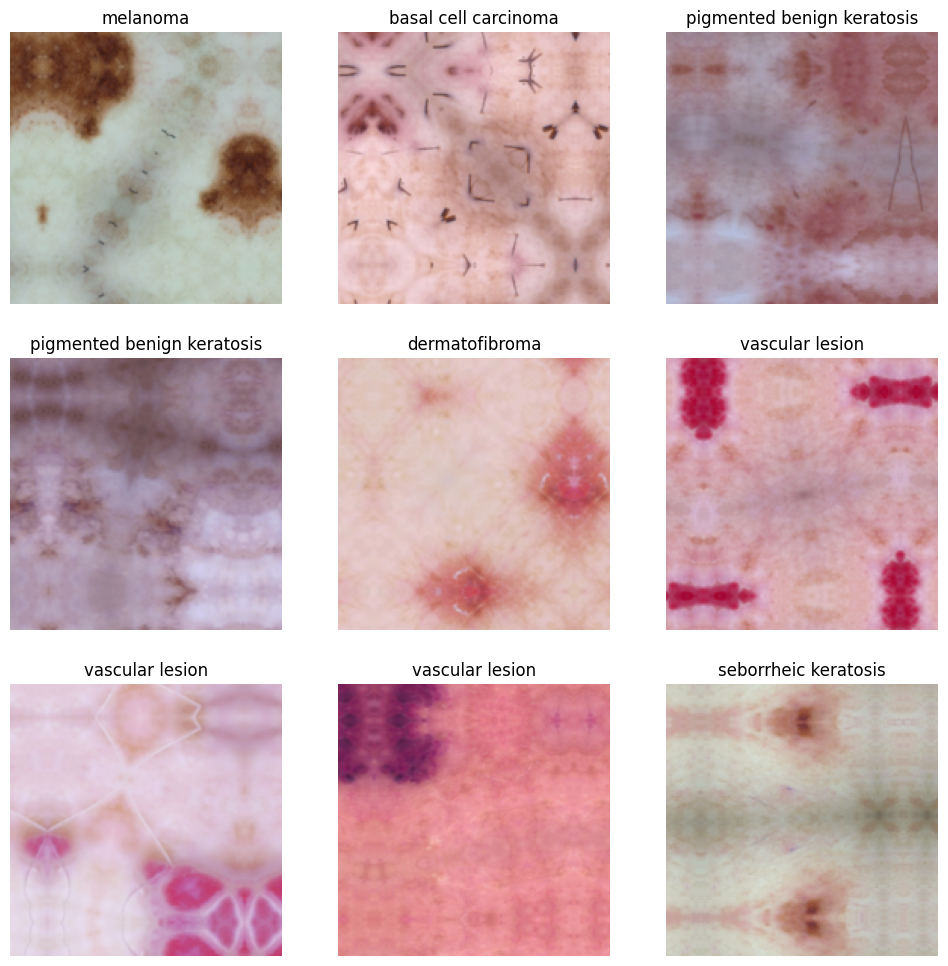

In [23]:
# Todo, visualize how your augmentation strategy works for one instance of training image.
plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [25]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

# Creating a simple CNN model

from tensorflow.keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Define the model
model = models.Sequential()

# Input layer with normalization
model.add(layers.InputLayer(input_shape=(img_height,img_width, 3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))  # Normalize pixel values to [0, 1]

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten the output
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))

# Output layer for 9 classes
model.add(layers.Dense(9, activation='softmax'))



### Compiling the model

In [26]:
## Your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_3 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_9 (Conv2D)           (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 89, 89, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_2 (Dropout)         (None, 43, 43, 64)       

### Training the model

In [27]:
## Your code goes here, note: train your model for 20 epochs

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 6s 63ms/step - loss: 2.3081 - accuracy: 0.1970 - val_loss: 2.0092 - val_accuracy: 0.2192
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.9022 - accuracy: 0.2902 - val_loss: 1.9307 - val_accuracy: 0.2640
Epoch 3/20
56/56 [==============================] - 3s 54ms/step - loss: 1.7009 - accuracy: 0.3956 - val_loss: 1.6043 - val_accuracy: 0.4251
Epoch 4/20
56/56 [==============================] - 3s 55ms/step - loss: 1.6459 - accuracy: 0.4090 - val_loss: 1.5787 - val_accuracy: 0.4407
Epoch 5/20
56/56 [==============================] - 3s 55ms/step - loss: 1.5873 - accuracy: 0.4291 - val_loss: 1.6300 - val_accuracy: 0.4027
Epoch 6/20
56/56 [==============================] - 3s 54ms/step - loss: 1.4879 - accuracy: 0.4665 - val_loss: 1.4772 - val_accuracy: 0.4810
Epoch 7/20
56/56 [==============================] - 3s 55ms/step - loss: 1.4283 - accuracy: 0.4950 - val_loss: 1.4090 - val_accuracy: 0.5123
Epoch 8/20
56

### Visualizing the results

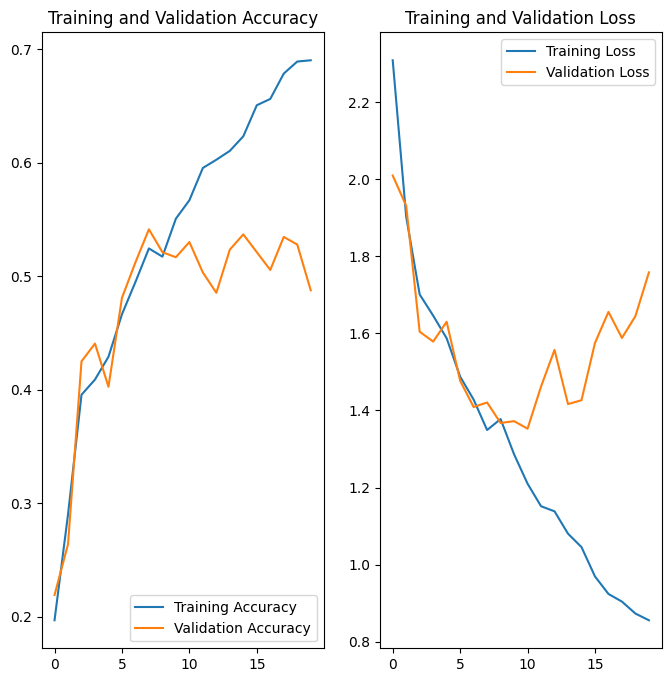

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

**Finding from Second Model**

*   There isn't a very signifant improvement in accuracy of validation dataset which has only improved marginally compared to the first model. But, we can definitely see the overfitting problem has improved since training accuracy has gone down in the range of 65-70% and the gap between training accuracy and validation accuracy has now reduced compared to First model.

*   But, since the validation accuracy in only around 50-55%, model needs further improvement.



# **Checking the distribution of classes in the training dataset**

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

<BarContainer object of 9 artists>

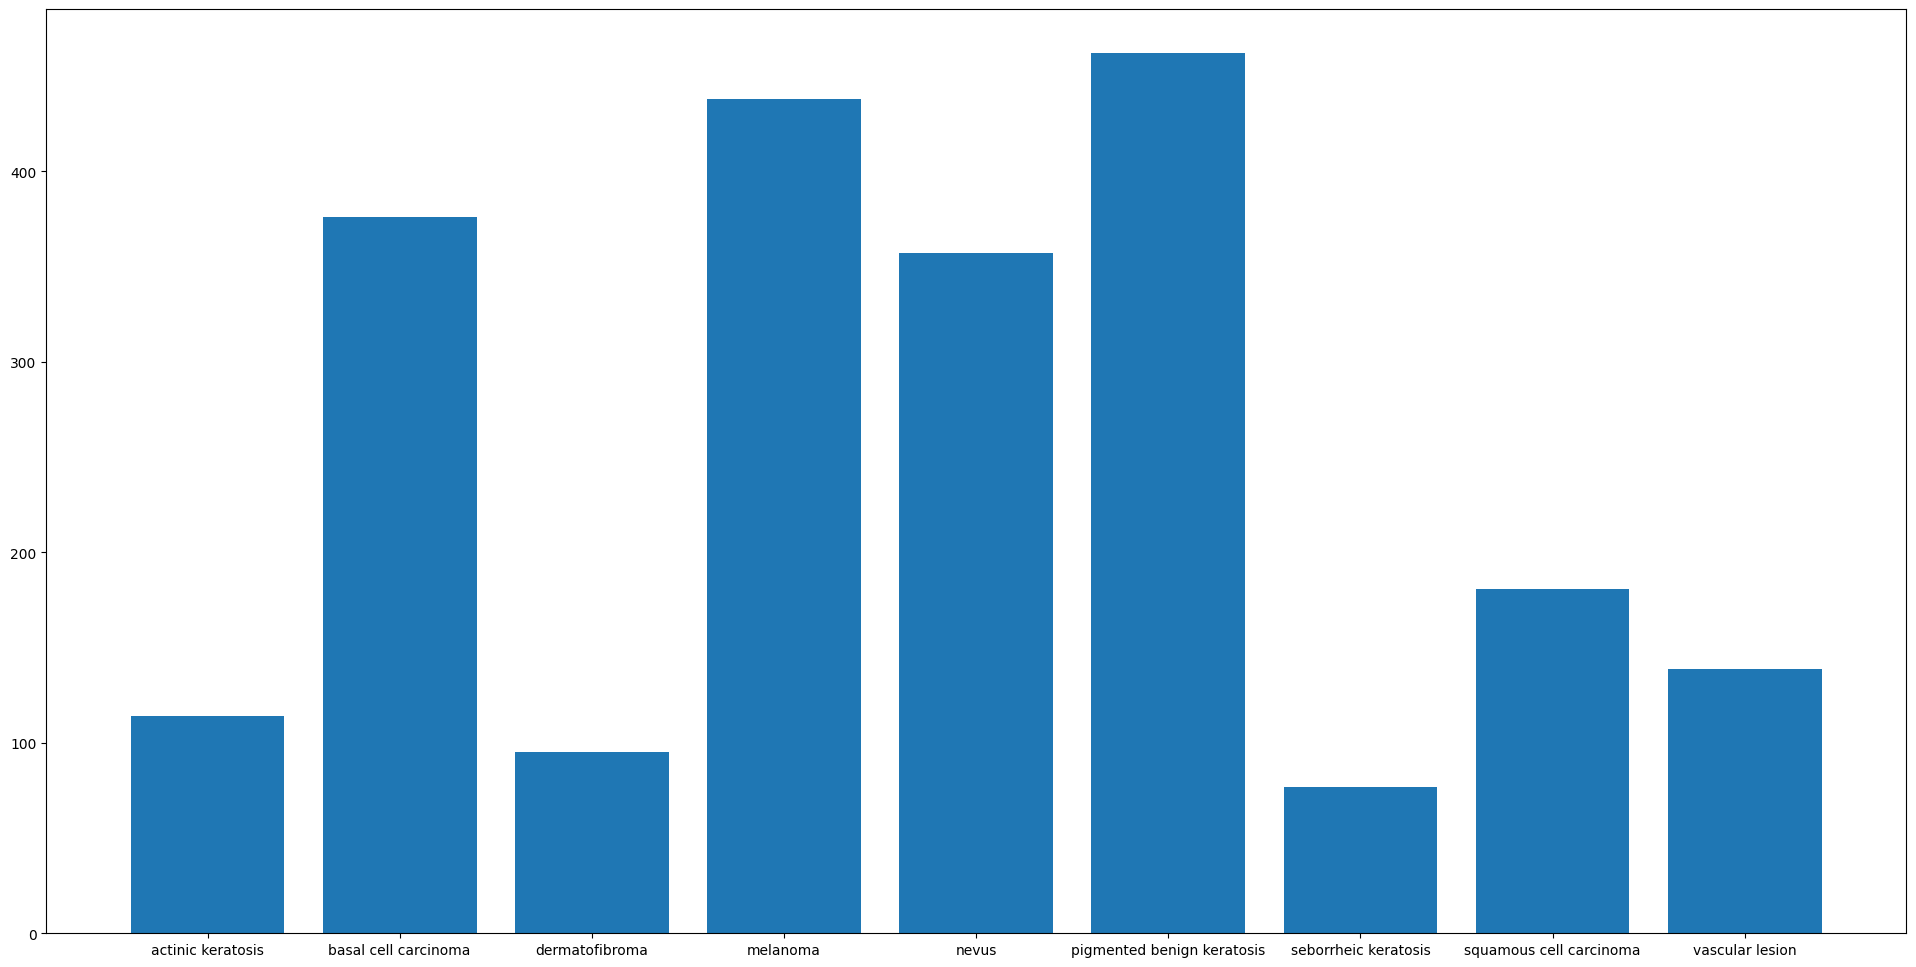

In [29]:
## Your code goes here.

path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

count=[]
for i in class_names:
    count.append(len(list(data_dir_train.glob(i+'/*.jpg'))))
plt.figure(figsize=(24,12))
plt.bar(class_names,count)



#### **Todo:** Write your findings here:
#### - Which class has the least number of samples?
#### - Which classes dominate the data in terms proportionate number of samples?


**Findings :**

- There is problem of **class imbalance** in the given dataset

- '**seborrheic keratosis**' has least number of samples

- **'melanoma', 'pigmented benign keratosis' and 'basal cell carcinoma'** dominate the dataset in terms of number of samples & have proprtionate number of classes

# **Rectifying the class imbalance**

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [30]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [32]:
path_to_training_dataset = data_dir_train
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(os.path.join(path_to_training_dataset,i))
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Initialised with 114 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D78FD323A60>: 100%|██████████| 500/500 [00:14<00:00, 34.23 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D7960191420>: 100%|██████████| 500/500 [00:14<00:00, 33.64 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D78FD35ADA0>: 100%|██████████| 500/500 [00:15<00:00, 32.12 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/melanoma/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D78FD33C760>: 100%|██████████| 500/500 [01:25<00:00,  5.83 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D78FD3BB5B0>: 100%|██████████| 500/500 [01:16<00:00,  6.55 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/pigmented benign keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D78FD4BEB30>: 100%|██████████| 500/500 [00:14<00:00, 34.75 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7D7A0BA6AB30>: 100%|██████████| 500/500 [00:34<00:00, 14.53 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/squamous cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D796FF355D0>: 100%|██████████| 500/500 [00:14<00:00, 34.68 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7D78FDB86230>: 100%|██████████| 500/500 [00:16<00:00, 30.61 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [33]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [34]:
import glob
path_list = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list

['/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0028926.jpg_b8205a7d-e2df-4483-834d-48b8fa1ccd4d.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0033808.jpg_43a31a24-9332-493d-aec0-326d7179ca4c.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025223.jpg_628c81cc-a63e-4ca7-81d9-66ffa5ddf784.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0025504.jpg_9e2ffe28-de35-4159-9285-3474520f3089.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Train/dermatofibroma/output/dermatofibroma_original_ISIC_0030870.jpg_09e6d70e-6cfb-4417-b809-1ac499b28110.jpg',
 '/content/Skin cancer ISIC The International Skin Imaging Collaboration/Tr

In [35]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
#lesion_list_new

In [37]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

In [41]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

In [42]:
df2['Label'].value_counts()

Label
dermatofibroma                500
basal cell carcinoma          500
seborrheic keratosis          500
nevus                         500
melanoma                      500
pigmented benign keratosis    500
vascular lesion               500
squamous cell carcinoma       500
actinic keratosis             500
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

# **THIRD MODEL: CNN MODEL AFTER CLASS BALANCE WITH AUGMENTATION & DROPOUT FEATURE**

#### **Todo**: Train the model on the data created using Augmentor

In [43]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [46]:
#data_dir_train="path to directory with training data + data created using augmentor"
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### **Todo:** Create a validation dataset

In [47]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',## Todo choose the correct parameter value, so that only validation data is refered to,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [48]:
from tensorflow.keras import models
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

# Define the model
model = models.Sequential()

# Input layer with normalization
model.add(layers.InputLayer(input_shape=(img_height,img_width, 3)))
model.add(layers.experimental.preprocessing.Rescaling(1./255))  # Normalize pixel values to [0, 1]

# First convolutional layer
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

# Second convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Third convolutional layer
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(Dropout(0.3))

# Flatten the output
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))

# Output layer for 9 classes
model.add(layers.Dense(9, activation='softmax'))

#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [49]:
## your code goes here

model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 180, 180, 3)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 178, 178, 32)      896       
                                                                 
 max_pooling2d_12 (MaxPooli  (None, 89, 89, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_13 (Conv2D)          (None, 87, 87, 64)        18496     
                                                                 
 max_pooling2d_13 (MaxPooli  (None, 43, 43, 64)        0         
 ng2D)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 43, 43, 64)       

#### **Todo:**  Train your model

In [50]:
epochs = 30

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)


## Your code goes here, use 50 epochs.
#history = # your model fit code

Epoch 1/30
169/169 [==============================] - 29s 160ms/step - loss: 2.0348 - accuracy: 0.2368 - val_loss: 1.7665 - val_accuracy: 0.3422
Epoch 2/30
169/169 [==============================] - 27s 154ms/step - loss: 1.5024 - accuracy: 0.4436 - val_loss: 1.3840 - val_accuracy: 0.4996
Epoch 3/30
169/169 [==============================] - 28s 160ms/step - loss: 1.3088 - accuracy: 0.5150 - val_loss: 1.3293 - val_accuracy: 0.5323
Epoch 4/30
169/169 [==============================] - 26s 150ms/step - loss: 1.1816 - accuracy: 0.5662 - val_loss: 1.2570 - val_accuracy: 0.5360
Epoch 5/30
169/169 [==============================] - 26s 150ms/step - loss: 1.0738 - accuracy: 0.6046 - val_loss: 1.1275 - val_accuracy: 0.5954
Epoch 6/30
169/169 [==============================] - 27s 153ms/step - loss: 0.9388 - accuracy: 0.6625 - val_loss: 1.0277 - val_accuracy: 0.6340
Epoch 7/30
169/169 [==============================] - 27s 153ms/step - loss: 0.8750 - accuracy: 0.6855 - val_loss: 1.0735 - val_ac

#### **Todo:**  Visualize the model results

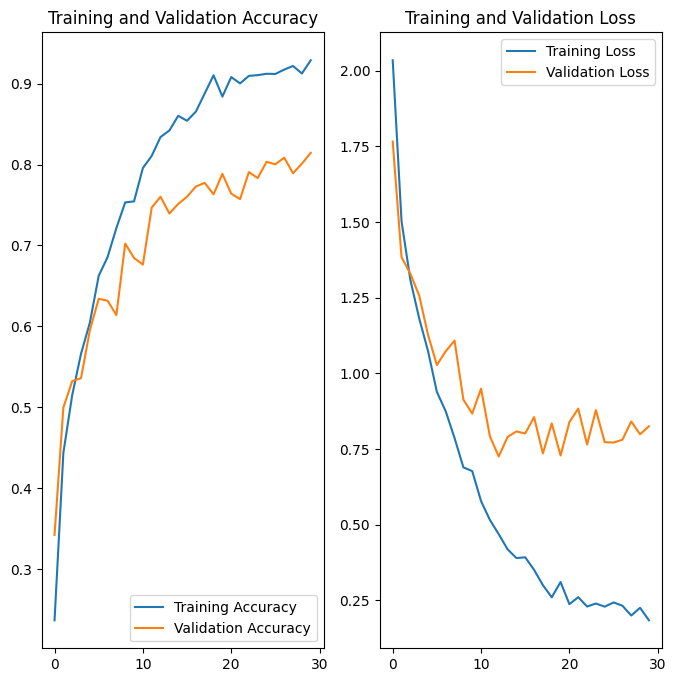

In [51]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?



**Findings of THIRD MODEL WITH CLASS REBALANCE**

- The model shows improved Validation Accuracy of nearly 80-82% as compared to the previous models without Class Rebalancing

- Gap between Training and Validation Accuracy has reduced.

- Training Losses have reduced below 0.25. However, Validation loss shows downward trend initially but increases gradually after around 15 epochs, signifying MODEL OVERFITTING.

- However, as compared to the previous Models, this model performed better than previous models